# Tyssue


The Tyssue python library allows to model mechanical behavior of 2D, apical 3D or full 3D epithelia.


![dimension](illus/dimension.png)

## Generate 2D epithelium


For this, we use a **Voronoï tessalation** of the cell centers.


![tessalation gif](illus/tessalation.gif)



In [18]:
%matplotlib inline

# Core object
from tyssue import Sheet
# Simple 2D geometry
from tyssue import PlanarGeometry as geom
# Visualisation
from tyssue.draw import sheet_view

sheet = Sheet.planar_sheet_2d(
    'basic2D', # a name or identifier for this sheet
    nx=6, # approximate number of cells on the x axis
    ny=7, # approximate number of cells along the y axis
    distx=1, # distance between 2 cells along x
    disty=1, # distance between 2 cells along y
    noise=0. # some position noise
)
geom.update_all(sheet)

# Give the tissue a nice hear cut ;)
sheet.sanitize(trim_borders=True, order_edges=True)
geom.update_all(sheet)

> Change the above parameters to see what happens

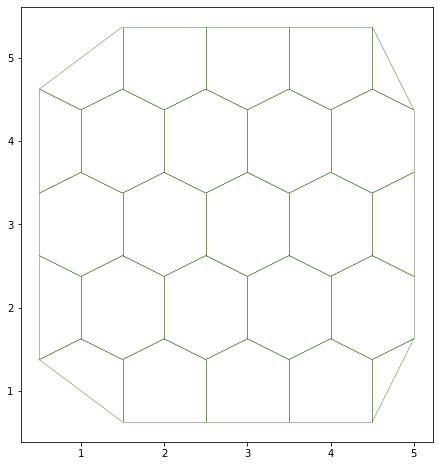

In [19]:
# Visualisation of the tissue
fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)

# Data structure


The tyssue library defines tissue as a meshes. A vertex model defines a tissue as an assembly of vertices and edges, which can form polygonal face (in 2D) or polyhedron (in 3D). 

![vertex](illus/vertexmodel.png)

The data associated with the mesh displayed above, i.e. the points positions, the connectivity information, etc. is stored in pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) objects, hold together in the `datasets` dictionnary.

Depending on the geometry, the following dataframes are populated:

- `datasets["edge"]` or `sheet.edge_df`: The edge related dataframe contains

    - the connectivity information: source and target vertices, associated face and (for thick tissues) the associated cell body.
    - geometry data associated with the edge, such as its length
    - any suplemental data, such as a color or a dynamical parameter (an elasticity for example)
    
- `datasets["vert"]` or `sheet.vert_df`: The vertices related dataframe. In the apical junction mesh above, those are the vertices at the cells junctions. It usually holds the coordinates of the points, and geometry or dynamical data.

- `datasets["face"]` or `sheet.face_df`: The faces related dataframe. For a thin, 2D tissue, this corresponds to a cell of the epithelium, delimited by its edges. In thick, 3D models, one cell has several faces (the apical, sagittal and basal ones for a 3D monolayer, for example).


- `datasets["cell"]` or `sheet.cell_df`: The cells related dataframe, only for 3D, thick, epithelium. Each cell have several faces.

## We use _half-edges_

Between two faces, an edge (a junction) is described by two entries in `sheet.edge_df`, one for each face. This simplifies some computations and algorithms, and allows to address each side of the junction separately.

![Half edges](illus/double_edges.svg)

In [20]:
sheet.face_df.head(5)

,y,is_alive,perimeter,area,x,num_sides,id
face,,,,,,,
0,1.250000,1,3.118034,0.5000,1.125000,4,0
1,1.125000,1,3.618034,0.8750,2.000000,5,0
2,1.125000,1,3.618034,0.8750,3.000000,5,0
3,1.125000,1,3.618034,0.8750,4.000000,5,0
4,1.208333,1,2.427051,0.1875,4.666667,3,0


In [21]:
sheet.edge_df.head(5)

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,ty,fx,fy,ux,uy,rx,ry,sub_area,is_valid,phi
edge,,,,,,,,,,,,,,,,,,,,
0,30,0.28125,0.750000,0,28,0.0,0.75,1.5,0.625,1.5,1.375,1.125,1.250,0.000000,1.000000,0.375,-0.625,0.140625,True,-0.643501
1,9,0.15625,0.559017,0,30,-0.5,0.25,1.5,1.375,1.0,1.625,1.125,1.250,-0.894427,0.447214,0.375,0.125,0.078125,True,0.643501
2,5,0.21875,0.559017,0,9,-0.5,-0.25,1.0,1.625,0.5,1.375,1.125,1.250,-0.894427,-0.447214,-0.125,0.375,0.109375,True,1.570796
3,28,0.34375,1.250000,0,5,1.0,-0.75,0.5,1.375,1.5,0.625,1.125,1.250,1.788854,-1.341641,-0.625,0.125,0.171875,True,1.570796
4,43,0.37500,0.750000,1,29,0.0,0.75,2.5,0.625,2.5,1.375,2.000,1.125,0.000000,1.000000,0.500,-0.500,0.187500,True,-0.643501


In [22]:
sheet.vert_df.head(5)

,y,is_active,x
vert,,,
0,3.625,1,1.0
1,3.375,1,0.5
2,4.625,1,0.5
3,4.375,1,1.0
4,3.375,1,1.5


#### Modifying the geometry


Most columns in the above dataframes are computed when the `geom.update_all` function is called. They depend only on the positions of the vertices, stored in `sheet.vert_df[['x', 'y']]`:

* The edge length are simply $\sqrt(x^2 + y^2)$ (Pythagoras represents).
* The face centers are the center of mass of the vertices positions. 

> Can you guess how the face areas are computed?

If we change those positions, we change all the values depending on them.

We can also see statistics or compute various derivated quantities.


In [23]:
avg_area = sheet.face_df['area'].mean()

print("Average cells area: ", avg_area)

Average cells area:  0.805


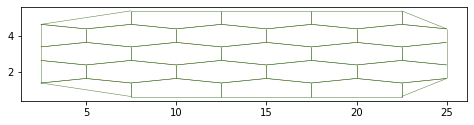

In [24]:
sheet.vert_df['x'] = sheet.vert_df['x'] * 5
geom.update_all(sheet)

fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)

> **exercice**
>
> Rescale the sheet correctly

<details><summary><b>Solution →</b></summary>

```py
sheet.vert_df['x'] = sheet.vert_df['x'] / 5
geom.update_all(sheet)
```

</details>

In [25]:
sheet.vert_df['x'] = sheet.vert_df['x'] / 5
geom.update_all(sheet)

> **exercice**
>
> Change the vertex positions so that the average area is close to 1.0, and update the geometry

<details><summary><b>Solution →</b></summary>

```py
sheet.vert_df[['x', 'y']] /= sheet.face_df.area.mean()
geom.update_all(sheet)
```

</details>

In [26]:
sheet.vert_df[['x', 'y']] /= sheet.face_df.area.mean()
geom.update_all(sheet)

# Simple quasi-static model


A common way to describe an epithelium is with the **quasistatic approximation**: we assume that at any point in time, without exterior perturbation, the epithelium is at an **energy minimum**. For a given expression of the model's Hamiltonian, we thus search the position of the vertices corresponding to the minimum of energy.

## The Farhadifar model

A very common formulation for the epithelium mechanical energy was given in [Farhadifar et al. in 2007](https://doi.org/10.1016/j.cub.2007.11.049).

The energy is the sum of an area elasticity, a contractility and a line tension:
$$
E = \sum_\alpha \frac{K_A}{2}(A_\alpha - A_0)^2 + \sum_\alpha \Gamma P_\alpha^2 + \sum_{ij} \Lambda \ell_{ij} 
$$

In tyssue, `Model` objects provide functions to compute the energy for a given epithelium,  as well as it's spatial derivatives over the vertices positions, the gradient.


The calculus is done with the columns of the dataframes, for exemple, if we set the value 0.12 for the term $\Lambda$ for all the edges of the epithelium:



In [27]:
sheet.edge_df["line_tension"] = 0.12
E_lt = (sheet.edge_df["length"] * sheet.edge_df["line_tension"]).sum()
print("Line tension energy : ", E_lt)

Line tension energy :  12.966751538757169


> **exercice**
>
> Add a "contractily" column in `sheet.face_df` with value 0.07
> & compute the energy associated with the contractility term above

<details><summary><b>Solution →</b></summary>

```py
sheet.face_df["contractility"] = 0.04
E_lt = (sheet.face_df["contractility"] * sheet.face_df["perimeter"]**2).sum()
print("Contractility energy : ", E_lt)
```

</details>

In [29]:
sheet.face_df["contractility"] = 0.04
E_lt = (sheet.face_df["contractility"] * sheet.face_df["perimeter"]**2).sum()
print("Contractility energy : ", E_lt)

Contractility energy :  18.91478258257701


This model has been predifined in tyssue as the default `PlanarModel`. We can use it in combination with a `Solver` object to find the energy minimum of our sheet.

To add the various columns in the dataframes (as we did above) we use a  **specification dictionnary** with the required parameters.

In [31]:
from tyssue.config.dynamics import quasistatic_plane_spec
from tyssue.dynamics.planar_vertex_model import PlanarModel as model
from tyssue.solvers import QSSolver
from pprint import pprint


# Update the specs (adds / changes the values in the dataframes' columns)
sheet.update_specs(quasistatic_plane_spec())

pprint(quasistatic_plane_spec())

{'edge': {'is_active': 1,
          'line_tension': 0.12,
          'ux': 0.0,
          'uy': 0.0,
          'uz': 0.0},
 'face': {'area_elasticity': 1.0,
          'contractility': 0.04,
          'is_alive': 1,
          'prefered_area': 1.0},
 'settings': {'grad_norm_factor': 1.0, 'nrj_norm_factor': 1.0},
 'vert': {'is_active': 1}}


In [32]:
E_t = model.compute_energy(sheet)
print("Total energy: ", E_t)

Total energy:  18.714361183679536


The energy minimum is found with a _gradient descent_ strategy, the vertices are displaced in the direction opposit to the spatial derivative of the energy. Actually, this defines the **force** on the vertices.


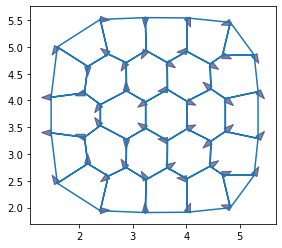

In [36]:
from tyssue.draw.plt_draw import plot_forces

fig, ax = plot_forces(sheet, geom, model, ['x', 'y'], 1)

Successfull gradient descent?  True


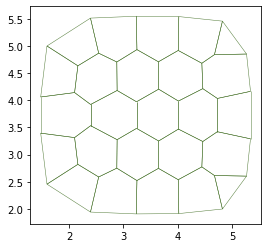

In [35]:
# Find energy minimum
solver = QSSolver()
res = solver.find_energy_min(sheet, 
                             geom,
                             model)

print("Successfull gradient descent? ", res['success'])
fig, ax = sheet_view(sheet)

## Effector classes


In some more details, the model is the collection of three **effectors**:

In [37]:
print('Planar model effectors :', end='\n\t')
print(*PlanarModel.labels, sep="\n\t")

Planar model effectors :
	Line tension
	Contractility
	Area elasticity



An effector designates a dynamical term in the epithelium governing equation. For quasistatic models, we need to provide  a method to compute the energy associated with this effector, and the corresponding gradient. 

For example, we can consider a line tension effector. The energy is $E_t = \sum_{ij} \Lambda\ell_{ij}$ where the sum is over all the edges. For each half-edge, the gradient of $E_t$ is defined by two terms, one for the gradient term associated with the half-edge ${ij}$ source, the over for it's target. For the $x$ coordinate:
$$
\frac{\partial E_t}{\partial x_i}
= \Lambda\left(\sum_k \frac{\partial \ell_{ik}}{\partial x_i} + \sum_m \frac{\partial \ell_{mi}}{\partial x_i}\right)
= \Lambda\left(\sum_k \frac{x_i}{\ell_{ik}}  - \sum_m \frac{x_i}{\ell_{mi}}\right)
$$

Where $\sum_k$ is are over all the edges which vertex $i$ is a source, and $\sum_m$ over all the edges of which vertex i is a target. 


Here is the definition of the line tension effector:
```python
class LineTension(AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension"
    label = "Line tension"
    element = "edge"
    specs = {"edge": {"is_active": 1, "line_tension": 1e-2}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* is_active" "* length / 2"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt
```

For quasistatic methods, this effectors are agregated with others to define a `model` object. This object will have two methods `compute_energy` and `compute_gradient` that take an `Epithelium` object as single argument.


# Simulating cell growth 

> **exercice**
>
> How would you simulate a single cell growth?

**Hint**: You can use [`loc`](https://pandas.pydata.org/docs/user_guide/indexing.html#selection-by-label) to access an element or a subelement of the dataframes. You can inspect `quasistatic_plane_spec()` to find the relevant columns.


<details><summary><b>Solution →</b></summary>
By increasing the equilibrium area of this cell:

```py
sheet.face_df.loc[12, "perefered_area"] *= 1.5
model.find_energy_min(sheet, geom, model)    
```
</details>

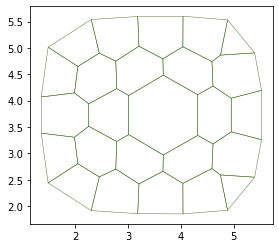

In [43]:
sheet.face_df.loc[12, "prefered_area"] *= 1.5
solver.find_energy_min(sheet, geom, model)  
fig, ax = sheet_view(sheet)

# Apoptosis

- passer sur un petit tissue en 2.5D 
- etape de l'apoptose
- Event manager


Here is the code for the apoptosis behavior:

```py
def apoptosis(sheet, manager, **kwargs):
    """Apoptotic behavior

    While the cell's apical area is bigger than a threshold, the
    cell shrinks, and the contractility of its neighbors is increased.
    once the critical area is reached, the cell is eliminated
    from the apical surface through successive type 1 transition. Once
    only three sides are left, the cell is eliminated from the tissue.

    Parameters
    ----------
    sheet : a :class:`Sheet` object
    manager : a :class:`EventManager` object
    face_id : int,
        the id of the apoptotic cell
    shrink_rate : float, default 0.1
        the rate of reduction of the cell's prefered volume
        e.g. the prefered volume is devided by a factor 1+shrink_rate
    critical_area : area at which the face is eliminated from the sheet
    radial_tension : amount of radial tension added at each contraction steps
    contractile_increase : increase in contractility at the cell neighbors
    contract_span : number of neighbors affected by the contracitity increase
    geom : the geometry class used
    """

    apoptosis_spec = default_apoptosis_spec
    apoptosis_spec.update(**kwargs)
    face = apoptosis_spec["face"]

    if sheet.face_df.loc[face, "area"] > apoptosis_spec["critical_area"]:
        # Shrink and pull
        shrink(sheet, face, apoptosis_spec["shrink_rate"])
        ab_pull(sheet, face, apoptosis_spec["radial_tension"])
        # contract neighbors
        neighbors = sheet.get_neighborhood(
            face, apoptosis_spec["contract_span"]
        ).dropna()
        neighbors["id"] = sheet.face_df.loc[neighbors.face, "id"].values
        manager.extend(
            [
                (
                    contraction,
                    {
                        "face_id": neighbor["id"],
                        "contractile_increase": (
                            apoptosis_spec["contractile_increase"] / neighbor["order"],
                        ),
                    },
                )
                for _, neighbor in neighbors.iterrows()
            ]
        )
        done = False
    else:
        if sheet.face_df.loc[face, "num_sides"] > 3:
            exchange(sheet, face, apoptosis_spec["geom"])
            done = False
        else:
            remove(sheet, face, apoptosis_spec["geom"])
            done = True
    if not done:
        manager.append(apoptosis, **apoptosis_spec)
```


In [ ]:

from tyssue.behaviors.sheet import apoptosis
from tyssue.behaviors import EventManager


manager = EventManager('face')


sheet.settings['apoptosis'] = {
    'shrink_rate': 1.2,
    'critical_area': 8.,
    'radial_tension': 0.2,
    'contractile_increase': 0.3,
    'contract_span': 2
    }

sheet.face_df['id'] = sheet.face_df.index.values
manager.append(apoptosis, face_id=apoptotic_cell, **sheet.settings['apoptosis'])

In [ ]:
t = 0
stop=100

progress = widgets.IntProgress(min=0, max=stop)
progress.value = 0
display(progress)

history = History(sheet)

while manager.current and t < stop:
    manager.execute(sheet)
    t += 1
    progress.value = t
    res = solver.find_energy_min(sheet, geom, model, **min_settings)
    history.record()
    manager.update()

In [ ]:

color = sheet.vert_df['y']
fig, mesh = sheet_view(sheet, coords=['z', 'x', 'y'], edge={"color":color}, mode="3D")
fig

In [ ]:

browse_history(history, edge={"color":lambda s : s.edge_df["length"]})

# "Ecriture" d'un effecteur

In [ ]:
import numpy as np
import pandas as pd

from tyssue import config, Sheet, PlanarGeometry
from tyssue.solvers import QSSolver

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw import sheet_view

from tyssue.dynamics.factory import model_factory
from tyssue.dynamics import effectors, units

from tyssue.utils import to_nd
from tyssue.utils.testing import effector_tester, model_tester
from tyssue.behaviors import EventManager
from tyssue.behaviors.sheet import basic_events

from tyssue.draw import highlight_faces, create_gif

In [ ]:
# create 2d patch of cell
geom = PlanarGeometry

sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
geom.update_all(sheet)

sheet.remove(sheet.cut_out([[0, 8], [0, 8]]), trim_borders=True)
sheet.sanitize()
geom.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
geom.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
fig, ax = sheet_view(sheet, mode="quick")

## Define the relevant mechanical components

In [ ]:

# Adding some gigling
class BrownianMotion(effectors.AbstractEffector):
    
    label = 'Brownian Motion'
    element = 'vert'
    specs = {"settings": {"temperature": 1e-3}}
    
    def energy(eptm):
        T = eptm.settings['temperature']
        return np.ones(eptm.Nv) * T / eptm.Nv
    
    def gradient(eptm):
        T = eptm.settings['temperature']
        scale = T/eptm.edge_df.length.mean()
        
        grad = pd.DataFrame(
            data=np.random.normal(0, scale=scale, size=(eptm.Nv, eptm.dim)),
            index=eptm.vert_df.index,
            columns=['g'+c for c in eptm.coords]
        )
        return grad, None

## Quasistatic gradient descent
With only the conservative potential terms

In [ ]:
model = model_factory(
    [effectors.PerimeterElasticity,
     BrownianMotion,
     effectors.LineTension,
     effectors.FaceAreaElasticity])


# setting up values for the whole epithelium
model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.05, # 1/2r in the master equation
        'prefered_perimeter': 3.81,
        "id": sheet.face_df.index
        },
    'vert': {
        "viscosity": 1.0
        },
    'edge': {'ux': 0, 'uy': 0},
    'settings': {
        'temperature': 2e-1,
        "p_4": 10.0,
        "p_5p": 1.0,
        "threshold_length": 2e-2
    }
}

sheet.update_specs(model_specs, reset=True)

res = QSSolver().find_energy_min(sheet, PlanarGeometry, model)

print(res.message)

In [ ]:
# Save the original sheet in a backup objet
bck = sheet.copy()

In [ ]:
def tract(eptm, face, pull_axis, value, pull_column='line_tension', face_id=None):
    """Modeling face traction as shrinking apical junctions on the neighouring cells,
    
    As if pseudopods where pulling between the cells
    
    
    """
    
    
    pull_axis = np.asarray(pull_axis)
    edges = eptm.edge_df.query(f'face == {face}')
    verts = edges['srce'].values
    r_ai = edges[["r"+c for c in eptm.coords]].values
    proj = (r_ai * pull_axis[None, :]).sum(axis=1)
    
    pulling_vert = verts[np.argmax(proj)]
    
    v_edges = eptm.edge_df.query(
        f'(srce == {pulling_vert}) & (face != {face})'
    )
    pulling_edges = v_edges[~v_edges['trgt'].isin(verts)].index
    eptm.edge_df[pull_column] = 0

    if pulling_edges.size:
        eptm.edge_df.loc[pulling_edges, pull_column] = value
        
        
default_traction_spec = {
    "face": -1,
    "face_id": -1,
    "pull_axis": [0.1, 0.9],
    "value": 4,
    "pull_column": "line_tension"
}


from tyssue.utils.decorators import face_lookup

@face_lookup
def traction(sheet, manager, **kwargs):
    
    traction_spec = default_traction_spec
    traction_spec.update(**kwargs)
    pulling = tract(sheet, **traction_spec)
    
    manager.append(traction, **traction_spec)

In [ ]:
pulled = 2

In [ ]:
# Euler solver + manager

# This allows to auomaticaly solve topology changes

manager = EventManager("face", )
manager.append(basic_events.reconnect)
manager.append(traction, face_id=pulled)

# Implicit Euler solver

solver = EulerSolver(
    sheet,
    geom,
    model,
    manager=manager,
    bounds=(
        -sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10
    )
)
manager.update()


sheet.face_df['prefered_perimeter'] = 3.8

In [ ]:
solver.solve(tf=120.0, dt=0.1)

highlight_faces(sheet.face_df, [pulled,], reset_visible=True)

fig, ax = sheet_view(
    sheet,
    mode="2D",
    face={"visible": True},
    edge={"head_width": 0.0, "color": sheet.edge_df["line_tension"]},
    vert={"visible": False}
)
fig.set_size_inches(6, 6)

# Full 3D 

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import Sheet, Monolayer, config

from tyssue.topology.monolayer_topology import cell_division

from tyssue import ClosedMonolayerGeometry as geom
from tyssue.solvers import QSSolver
from tyssue.generation import extrude


from tyssue.dynamics import effectors, model_factory

from tyssue.draw import sheet_view

from tyssue.io.hdf5 import save_datasets, load_datasets

In [ ]:
specs = config.geometry.bulk_spec()

sheet = Sheet.planar_sheet_3d('flat', 4, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')
mono = Monolayer('mono', datasets, specs)

geom.center(mono)
geom.update_all(mono)


# ## Settings for the quasi-static model
model = model_factory([effectors.LumenVolumeElasticity,
                       effectors.CellVolumeElasticity,
                       effectors.CellAreaElasticity,
                       effectors.LineTension],
                      effectors.CellVolumeElasticity)

dyn_specs = config.dynamics.quasistatic_bulk_spec()
dyn_specs['cell']['area_elasticity'] = 0.05
dyn_specs['cell']['prefered_area'] = 6.
dyn_specs['cell']['vol_elasticity'] = 1.
dyn_specs['cell']['prefered_vol'] = 1.2
dyn_specs['face']['contractility'] = 0.0
dyn_specs['edge']['line_tension'] = 0.0


mono.update_specs(dyn_specs, reset=True)


mono.face_df.loc[mono.apical_faces, 'contractility'] = 1e-3
mono.face_df.loc[mono.basal_faces, 'contractility'] = 1e-3

res = Solver.find_energy_min(mono, geom, model)

In [ ]:
from tyssue.behaviors.events import EventManager
from tyssue.behaviors.monolayer_events import apoptosis

#Initiate manager
manager = EventManager('face')
sheet.face_df['enter_in_process'] = 0  

t=0
stop = 20

settings = {'contract_rate': 2,
            'critical_area': 0.02,
            'shrink_rate': 0.4,
            'critical_volume': 0.1}
contract_rate= 2
critical_area= 0.02
shrink_rate= 0.4
critical_volume= 0.1

manager.append(apoptosis, 4, (contract_rate,
            critical_area,
            shrink_rate,
            critical_volume))

while manager.current and t<stop:
    print (t)
    manager.execute(mono)
    res = Solver.find_energy_min(mono, geom, model)
    manager.update()
    t+=1

In [ ]:

def view3d(mono):
    ipv.clear()
    draw_spec = config.draw.sheet_spec()
    draw_spec['face']['visible'] = True 
    draw_spec['face']['color'] = mono.face_df.area
    draw_spec['face']['color_range'] = (0, 1)
    # function plotting two meshes
    fig, meshes = sheet_view(mono, mode='3D', **draw_spec)
    fig = ipv.gcf()

    #mesh = ipv.examples.klein_bottle(show=False)
    #fig.meshes = fig.meshes + [mesh, ]
    fig.anglex = 1.0
    fig.angley = 0.2
    fig.anglez = 0.1
    
    ipv.show()
    #timestamp = datetime.now().isoformat().replace(':', '').replace('.', '_')
    #ipv.savefig(f'{mono.identifier}_{timestamp}.png')
    

In [ ]:
view3d(mono)

In [ ]:
highlight_cells(mono, 4)
view3d(mono)

In [ ]:
from tyssue.behaviors.events import EventManager
from tyssue.behaviors.monolayer_events import apoptosis

#Initiate manager
manager = EventManager('face')
sheet.face_df['enter_in_process'] = 0  

t=0
stop = 20

settings = {'contract_rate': 2,
            'critical_area': 0.02,
            'shrink_rate': 0.4,
            'critical_volume': 0.1}
contract_rate= 2
critical_area= 0.02
shrink_rate= 0.4
critical_volume= 0.1

manager.append(apoptosis, 4, (contract_rate,
            critical_area,
            shrink_rate,
            critical_volume))

while manager.current and t<stop:
    print (t)
    manager.execute(mono)
    res = Solver.find_energy_min(mono, geom, model)
    manager.update()
    t+=1

In [ ]:
mono.face_df.visible=True
view3d(mono)

In [ ]:
highlight_cells(mono, 4, reset_visible=True)
view3d(mono)